In [1]:
import os
import urllib
import csv
from concurrent.futures import ThreadPoolExecutor, wait, ALL_COMPLETED
from astropy.io import fits
import matplotlib.pyplot as plt
import itertools
import pandas as pd

# Download data

In [ ]:
def download(url,to_dir,filename):
    fdir = to_dir + filename.split('/')[-1]
    print('start downloading %s' %url)
    urllib.request.urlretrieve(url, filename=fdir)
    print('finish downloading %s' %url)

In [ ]:
# download_list = 'star.csv'
download_list = 'galaxy.csv'
# download_list = 'qso.csv'
# to_dir = './LAMOST_spectra/star/'
# to_dir = './LAMOST_spectra/galaxy/'
# to_dir = '/Users/qyq/Development/Python天文培训/qso/'
to_dir = '/Users/qyq/Development/Python天文培训/galaxy/'
url_reader = itertools.islice(csv.DictReader(open(download_list),delimiter='|'),2000)
filenames = [row['obsfits_file'].split('/')[-1] for row in url_reader]
print(filenames)

In [ ]:
print(f"Size of filenames is {len(filenames)}")

In [ ]:
filenames[0].split('/')[-1]

In [ ]:
filenames[0]

In [ ]:
url_reader = itertools.islice(csv.DictReader(open(download_list),delimiter='|'),2000)
urls = ['http://dr5.lamost.org/v3/spectrum/fits/'+ row['catalogue_obsid'] for row in url_reader]
print(urls)

In [ ]:
print(f"Size of urls is {len(urls)}")

In [ ]:
for (url,filename) in zip(urls,filenames):
    download(url,to_dir,filename)

# Data preparation

In [2]:
# datadir='./LAMOST_spectra/star'
# datadir='/Users/qyq/Development/Python天文培训/qso/'
datadir = '/Users/qyq/Development/Python天文培训/galaxy/'
# datadir='./LAMOST_spectra/galaxy'
filenames = os.listdir(datadir)
filepaths = [os.path.join(datadir, filename) for filename in filenames if 'fits'in filename]
wavelength_list =[]
flux_list=[]
for file in filepaths[:2000]:
    hdulist = fits.open(file)
    flux = hdulist[0].data[0]
    flux_list.append(flux)
    wavelength = hdulist[0].data[2]
    wavelength_list.append(wavelength)

In [3]:
hdulist[0].data[0]

array([6.6860113 , 2.5645337 , 0.42997545, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [4]:
len(hdulist[0].data[2])

3909

In [5]:
wavelength_list

099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9088.665 , 9090.759 ,
        9092.852 ], dtype=float32),
 array([3700.    , 3700.852 , 3701.7043, ..., 8910.492 , 8912.545 ,
        8914.597 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9088.665 , 9090.759 ,
        9092.852 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9088.665 , 9090.759 ,
        9092.852 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.6907, ..., 9094.945 , 9097.04  ,
        9099.135 ], dtype=float32),
 array([3699.9863, 3700.8384, 3701.69

In [6]:
print(f"Size of wavelenth_list is ({len(wavelength_list)},{len(wavelength_list[0])})")

Size of wavelenth_list is (2000,3909)


In [7]:
flux_list

       27.391003 ], dtype=float32),
 array([32.879574, 20.850458, 52.828167, ..., 39.34002 , 57.164425,
        36.690163], dtype=float32),
 array([ 7.679377 ,  4.7893085, 11.38967  , ...,  0.       ,  0.       ,
         0.       ], dtype=float32),
 array([ -5.3075275,  50.048603 , 139.18863  , ...,   0.       ,
          0.       ,   0.       ], dtype=float32),
 array([ 8.511603 , 21.61668  , -1.8867942, ...,  0.       ,  0.       ,
         0.       ], dtype=float32),
 array([-0.12477434,  2.3350837 ,  2.3014014 , ...,  1.5968342 ,
         1.9257014 ,  1.6393161 ], dtype=float32),
 array([19.762636, 11.556786, 28.35569 , ...,  0.      ,  0.      ,
         0.      ], dtype=float32),
 array([32.453445, 29.413486, 14.495909, ...,  0.      ,  0.      ,
         0.      ], dtype=float32),
 array([-9.682584 , 20.238825 , -4.0188594, ...,  0.       ,  0.       ,
         0.       ], dtype=float32),
 array([-3.2949185, 48.124195 , 33.004322 , ...,  0.       ,  0.       ,
         0.      

每条光谱的波长值不完全一致，插值取共同值

In [8]:
WAVE_LENGTH_BEGIN = 3800
WAVE_LENGTH_END = 8900
WAVE_LENGTH_INTERVAL = 2
def calculate_interpolation(left, right, pos):
        ratio = (pos-left[0])/(right[0]-left[0])
        new_flux = (right[1]-left[1])*ratio + left[1]
        return pos, new_flux
    
def interpolation(wavelength,flux):
    pos_list = []
    target_list = []
    for pos in range(WAVE_LENGTH_BEGIN, WAVE_LENGTH_END, WAVE_LENGTH_INTERVAL):
        pos_list.append(pos)
    source = [(wavelength[i], flux[i]) for i in range(len(flux))]
    wave_index = 0
    right_wave_length = source[wave_index+1][0]
    
    for pos in pos_list:
        while pos > right_wave_length:
            wave_index += 1
            try:
                right_wave_length = source[wave_index+1][0]
            except Exception:
                raise 
        if pos == right_wave_length:
            target_list.append((source[wave_index + 1][1]))
        else:
            new_point = calculate_interpolation(source[wave_index],source[wave_index + 1],
                                                                             pos)
            target_list.append(new_point[1])
    return target_list

In [9]:
interpolated_qso =[]

In [10]:
for wavelength,flux in zip(wavelength_list, flux_list):
    try:
        interpolated_qso.append(interpolation(wavelength,flux))
    except Exception:
        print(wavelength,len(flux))

In [11]:
interpolated_qso = pd.DataFrame(interpolated_qso)

In [12]:
interpolated_qso

,0,1,2,3,4,5,6,7,8,9,...,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549
0,9.871638,15.206643,15.198416,20.218092,6.895023,4.073161,4.811073,9.103910,18.032542,8.598172,...,11.981676,11.054464,17.305203,9.034326,0.563043,8.774158,15.349003,14.858025,12.491949,11.477388
1,4.862527,10.859680,9.971026,7.836308,-3.429501,16.170773,-7.564232,-14.481483,-14.841345,13.550703,...,26.081286,28.075348,27.961022,26.519381,28.592656,30.063722,26.463568,27.309051,27.578037,26.328712
2,0.908007,14.656344,17.175795,22.730709,27.552599,24.402164,2.177851,12.549483,6.616745,8.914246,...,37.589822,37.550488,44.430830,45.581105,43.135989,36.640215,20.903487,40.248536,40.059822,42.129030
3,9.068633,3.486067,5.581208,10.241788,-15.982851,3.477587,-6.878169,-9.828988,12.123289,24.442343,...,0.034792,0.846770,14.573741,5.615799,6.735948,13.465499,-3.819559,2.756726,3.572708,3.366537
4,0.333531,-1.384891,-0.648527,-2.032861,0.299313,-0.604456,-1.961531,-9.391174,2.716565,1.648619,...,4.643586,5.483612,6.437015,13.253737,4.509517,3.364400,0.757174,4.895775,4.297915,3.960066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,24.434528,16.085550,34.088196,36.117012,41.604464,38.046837,39.030571,39.295759,29.002910,40.104957,...,87.724727,88.142789,100.146210,97.271809,90.713197,85.797742,93.720802,89.583868,92.497904,93.644473
1996,33.002414,22.317318,22.902831,22.643702,27.222679,26.166203,24.588483,22.984528,17.159675,19.946667,...,67.546415,65.904755,68.107197,65.002342,67.916629,66.594163,66.086660,63.811682,65.277794,63.893413
1997,18.569025,27.162632,17.780405,16.853908,38.833548,58.618161,-8.247452,57.339510,13.277077,57.878642,...,56.296113,61.276000,60.045402,60.365349,66.749203,64.007549,57.389456,52.606965,54.301444,60.368469
1998,13.037171,7.596011,16.866054,19.895239,28.670282,13.755452,21.503841,18.396442,16.168968,20.738682,...,22.763899,26.789913,31.111967,17.199127,24.398351,25.083028,25.984781,22.095849,23.393530,22.977729


In [13]:
interpolated_spectra = interpolated_qso

In [14]:
interpolated_spectra['type']=2 # 2 for galaxy, 3 for qso

In [15]:
interpolated_spectra

,0,1,2,3,4,5,6,7,8,9,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,type
0,9.871638,15.206643,15.198416,20.218092,6.895023,4.073161,4.811073,9.103910,18.032542,8.598172,...,11.054464,17.305203,9.034326,0.563043,8.774158,15.349003,14.858025,12.491949,11.477388,2
1,4.862527,10.859680,9.971026,7.836308,-3.429501,16.170773,-7.564232,-14.481483,-14.841345,13.550703,...,28.075348,27.961022,26.519381,28.592656,30.063722,26.463568,27.309051,27.578037,26.328712,2
2,0.908007,14.656344,17.175795,22.730709,27.552599,24.402164,2.177851,12.549483,6.616745,8.914246,...,37.550488,44.430830,45.581105,43.135989,36.640215,20.903487,40.248536,40.059822,42.129030,2
3,9.068633,3.486067,5.581208,10.241788,-15.982851,3.477587,-6.878169,-9.828988,12.123289,24.442343,...,0.846770,14.573741,5.615799,6.735948,13.465499,-3.819559,2.756726,3.572708,3.366537,2
4,0.333531,-1.384891,-0.648527,-2.032861,0.299313,-0.604456,-1.961531,-9.391174,2.716565,1.648619,...,5.483612,6.437015,13.253737,4.509517,3.364400,0.757174,4.895775,4.297915,3.960066,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,24.434528,16.085550,34.088196,36.117012,41.604464,38.046837,39.030571,39.295759,29.002910,40.104957,...,88.142789,100.146210,97.271809,90.713197,85.797742,93.720802,89.583868,92.497904,93.644473,2
1996,33.002414,22.317318,22.902831,22.643702,27.222679,26.166203,24.588483,22.984528,17.159675,19.946667,...,65.904755,68.107197,65.002342,67.916629,66.594163,66.086660,63.811682,65.277794,63.893413,2
1997,18.569025,27.162632,17.780405,16.853908,38.833548,58.618161,-8.247452,57.339510,13.277077,57.878642,...,61.276000,60.045402,60.365349,66.749203,64.007549,57.389456,52.606965,54.301444,60.368469,2
1998,13.037171,7.596011,16.866054,19.895239,28.670282,13.755452,21.503841,18.396442,16.168968,20.738682,...,26.789913,31.111967,17.199127,24.398351,25.083028,25.984781,22.095849,23.393530,22.977729,2


In [ ]:
# interpolated_spectra.loc[:2,'type']=2

In [ ]:
# interpolated_spectra

In [16]:
pos_list = []
for pos in range(WAVE_LENGTH_BEGIN, WAVE_LENGTH_END, WAVE_LENGTH_INTERVAL):
    pos_list.append(pos)

In [ ]:
pos_list

In [17]:
interpolated_spectra.iloc[0][:2550]

0        9.871638
1       15.206643
2       15.198416
3       20.218092
4        6.895023
          ...    
2545     8.774158
2546    15.349003
2547    14.858025
2548    12.491949
2549    11.477388
Name: 0, Length: 2550, dtype: float64

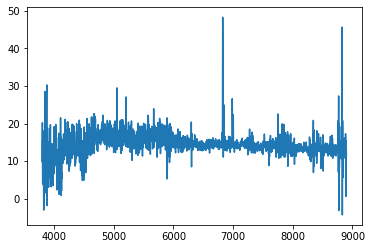

In [18]:
plt.plot(pos_list,interpolated_spectra.iloc[0][:2550])

In [19]:
spectra_means = interpolated_spectra.mean(1).to_numpy() # calculate mean values according to columns
spectra_means

array([14.47770317, 24.01404518, 34.48200229, ..., 62.86432127,
       27.31463626, 11.82438134])

In [20]:
interpolated_spectra.mean?

Signature:
interpolated_spectra.mean(
    axis=None,
    skipna=None,
    level=None,
    numeric_only=None,
    **kwargs,
)
Docstring:
Return the mean of the values over the requested axis.

Parameters
----------
axis : {index (0), columns (1)}
    Axis for the function to be applied on.
skipna : bool, default True
    Exclude NA/null values when computing the result.
level : int or level name, default None
    If the axis is a MultiIndex (hierarchical), count along a
    particular level, collapsing into a Series.
numeric_only : bool, default None
    Include only float, int, boolean columns. If None, will attempt to use
    everything, then use only numeric data. Not implemented for Series.
**kwargs
    Additional keyword arguments to be passed to the function.

Returns
-------
Series or DataFrame (if level specified)
File:      ~/Library/Python/3.8/lib/python/site-packages/pandas/core/generic.py
Type:      method


In [21]:
len(spectra_means)

2000

In [22]:
interpolated_spectra_list = interpolated_spectra.to_numpy()
print(f"Size of interpolated_spectra_list is ({len(interpolated_spectra_list)},{len(interpolated_spectra_list[0])})")

Size of interpolated_spectra_list is (2000,2551)


In [23]:
interpolated_spectra_list

array([[ 9.87163812, 15.20664255, 15.19841621, ..., 12.49194945,
        11.47738792,  2.        ],
       [ 4.86252659, 10.85967966,  9.97102641, ..., 27.57803739,
        26.32871162,  2.        ],
       [ 0.90800713, 14.65634382, 17.17579548, ..., 40.05982233,
        42.12902984,  2.        ],
       ...,
       [18.56902544, 27.16263227, 17.78040548, ..., 54.30144384,
        60.36846909,  2.        ],
       [13.0371707 ,  7.59601146, 16.8660545 , ..., 23.39353009,
        22.97772895,  2.        ],
       [ 6.30956691,  4.03760638,  5.74888703, ..., 10.75231471,
        11.73304624,  2.        ]])

In [24]:
standardised_spectra_list=[]
for i,spectra in enumerate(interpolated_spectra_list):
    standardised = spectra/spectra_means[i]
    standardised_spectra_list.append(standardised)

In [25]:
standardised_spectra = pd.DataFrame(standardised_spectra_list)
standardised_spectra

,0,1,2,3,4,5,6,7,8,9,...,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
0,0.681851,1.050349,1.049781,1.396499,0.476251,0.281340,0.332309,0.628823,1.245539,0.593891,...,0.763551,1.195300,0.624017,0.038890,0.606046,1.060182,1.026270,0.862841,0.792763,0.138143
1,0.202487,0.452222,0.415216,0.326322,-0.142812,0.673388,-0.314992,-0.603042,-0.618028,0.564282,...,1.169122,1.164361,1.104328,1.190664,1.251922,1.102004,1.137212,1.148413,1.096388,0.083285
2,0.026333,0.425043,0.498109,0.659205,0.799043,0.707678,0.063159,0.363943,0.191890,0.258519,...,1.088988,1.288522,1.321881,1.250971,1.062590,0.606214,1.167233,1.161760,1.221769,0.058001
3,2.434612,0.935888,1.498360,2.749564,-4.290839,0.933611,-1.846549,-2.638741,3.254681,6.561919,...,0.227328,3.912542,1.507647,1.808368,3.615018,-1.025419,0.740085,0.959148,0.903798,0.536930
4,0.060074,-0.249441,-0.116810,-0.366151,0.053911,-0.108872,-0.353303,-1.691500,0.489297,0.296942,...,0.987686,1.159409,2.387209,0.812236,0.605982,0.136379,0.881807,0.774123,0.713271,0.360232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.291582,0.191952,0.406782,0.430992,0.496475,0.454021,0.465760,0.468925,0.346098,0.478581,...,1.051827,1.195066,1.160765,1.082500,1.023843,1.118390,1.069023,1.103797,1.117479,0.023866
1996,0.537349,0.363373,0.372906,0.368687,0.443242,0.426041,0.400352,0.374236,0.279396,0.324774,...,1.073068,1.108928,1.058375,1.105826,1.084293,1.076030,1.038988,1.062860,1.040319,0.032564
1997,0.295383,0.432083,0.282838,0.268100,0.617736,0.932455,-0.131194,0.912115,0.211202,0.920691,...,0.974734,0.955159,0.960248,1.061798,1.018186,0.912910,0.836833,0.863788,0.960298,0.031815
1998,0.477296,0.278093,0.617473,0.728373,1.049631,0.503593,0.787264,0.673501,0.591953,0.759252,...,0.980790,1.139022,0.629667,0.893234,0.918300,0.951313,0.808938,0.856447,0.841224,0.073221


In [26]:
standardised_spectra.drop(2550,axis=1, inplace=True) # mean value of "type", no sense

In [27]:
standardised_spectra

,0,1,2,3,4,5,6,7,8,9,...,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549
0,0.681851,1.050349,1.049781,1.396499,0.476251,0.281340,0.332309,0.628823,1.245539,0.593891,...,0.827595,0.763551,1.195300,0.624017,0.038890,0.606046,1.060182,1.026270,0.862841,0.792763
1,0.202487,0.452222,0.415216,0.326322,-0.142812,0.673388,-0.314992,-0.603042,-0.618028,0.564282,...,1.086085,1.169122,1.164361,1.104328,1.190664,1.251922,1.102004,1.137212,1.148413,1.096388
2,0.026333,0.425043,0.498109,0.659205,0.799043,0.707678,0.063159,0.363943,0.191890,0.258519,...,1.090129,1.088988,1.288522,1.321881,1.250971,1.062590,0.606214,1.167233,1.161760,1.221769
3,2.434612,0.935888,1.498360,2.749564,-4.290839,0.933611,-1.846549,-2.638741,3.254681,6.561919,...,0.009340,0.227328,3.912542,1.507647,1.808368,3.615018,-1.025419,0.740085,0.959148,0.903798
4,0.060074,-0.249441,-0.116810,-0.366151,0.053911,-0.108872,-0.353303,-1.691500,0.489297,0.296942,...,0.836384,0.987686,1.159409,2.387209,0.812236,0.605982,0.136379,0.881807,0.774123,0.713271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.291582,0.191952,0.406782,0.430992,0.496475,0.454021,0.465760,0.468925,0.346098,0.478581,...,1.046838,1.051827,1.195066,1.160765,1.082500,1.023843,1.118390,1.069023,1.103797,1.117479
1996,0.537349,0.363373,0.372906,0.368687,0.443242,0.426041,0.400352,0.374236,0.279396,0.324774,...,1.099798,1.073068,1.108928,1.058375,1.105826,1.084293,1.076030,1.038988,1.062860,1.040319
1997,0.295383,0.432083,0.282838,0.268100,0.617736,0.932455,-0.131194,0.912115,0.211202,0.920691,...,0.895518,0.974734,0.955159,0.960248,1.061798,1.018186,0.912910,0.836833,0.863788,0.960298
1998,0.477296,0.278093,0.617473,0.728373,1.049631,0.503593,0.787264,0.673501,0.591953,0.759252,...,0.833396,0.980790,1.139022,0.629667,0.893234,0.918300,0.951313,0.808938,0.856447,0.841224


In [28]:
standardised_spectra['type']=2 # 2 for galaxy, 3 for qso

In [29]:
# standardised_spectra.to_csv(r'/Users/qyq/Development/Python天文培训/qso_standardised.csv',index=False)
standardised_spectra.to_csv(r'/Users/qyq/Development/Python天文培训/galaxy_standardised.csv',index=False)

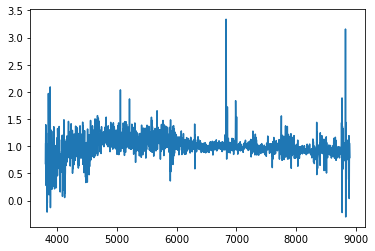

In [30]:
plt.plot(pos_list,standardised_spectra.iloc[0][:2550])

# Check data

In [ ]:
galaxies = pd.read_csv('/Users/qyq/Development/Python天文培训/galaxy_standardised.csv')

In [ ]:
galaxies

In [ ]:
qsos = pd.read_csv('/Users/qyq/Development/Python天文培训/qso_standardised.csv')
qsos